# MOA Evaluation using enrichment analysis

- Adopted here: https://www.nature.com/articles/s41467-019-10154-8
- Explained here: https://yulab-smu.github.io/clusterProfiler-book/chapter2.html

### Procedure:
1. Compute similarity / correlation / affinity matrix
1. Define MOA matching criteria based on metadata
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L67
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L190
1. Find the threshold of top connections (percentile)
1. Run enrichment analysis (one-sided version of Fisher's exact test)
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L97
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L205

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sys

sys.path.append("../profiling/")

import metrics
import quality
import profiling

# Load correlation matrix

In [2]:
CORR_MATRIX = "data/correlation_matrix.csv"
#CORR_MATRIX = "data/cr_median_clean.csv"

In [3]:
# df = pd.read_csv("data/cr_median.csv")
# clean = df[df["Unnamed: 0"].isin(df.groupby(["Var1","Var2","value"])["Unnamed: 0"].max().reset_index()["Unnamed: 0"])]
# clean.to_csv("data/cr_median_clean.csv", index=False)

In [4]:
X, Y = profiling.load_correlation_matrix(CORR_MATRIX)

In [5]:
# Z = Y.groupby(["Var1"]).max().reset_index()
# Z[["Var1", "Metadata_moa.x", "Metadata_Plate_Map_Name.x"]].to_csv("data/CDRP_MOA_MATCHES.csv")

# MOA matching

In [6]:
Y.groupby("Metadata_moa.x")["Var1"].count()

Metadata_moa.x
1,3-beta-glucan synthase inhibitor                1
11-beta hydroxysteroid dehydrogenase inhibitor    3
11-beta-HSD1 inhibitor                            1
3-ketoacyl CoA thiolase inhibitor                 1
5 alpha reductase inhibitor                       2
                                                 ..
vitamin B                                         1
vitamin B2                                        1
vitamin D receptor agonist                        2
vitamin K antagonist                              1
voltage-independent calcium influx blocker        1
Name: Var1, Length: 676, dtype: int64

In [7]:
moa_matches = []
for k,r in Y.iterrows():
    m = Y["Metadata_moa.x"] == r["Metadata_moa.x"]
    moa_matches.append(m)

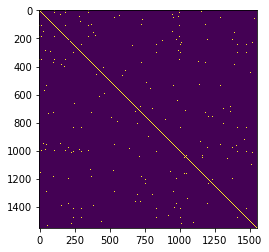

In [8]:
moa_matches = np.asarray(moa_matches)
plt.imshow(moa_matches)

# Enrichment analysis

In [9]:
results = []
Z = np.asarray(X[Y.Var1])
ut_idx = np.triu_indices(moa_matches.shape[1], k=1)

for p in np.arange(98, 99.7, 0.2):
    r = quality.enrichment_analysis_matrix(Z[ut_idx], moa_matches[ut_idx], p)
    results.append(r)

R = pd.DataFrame(data=results)

98.0 0.5988029968244579
[[    245   23796]
 [   4686 1173298]] 1202025
98.2 0.6091723151438397
[[    225   21412]
 [   4706 1175682]] 1202025
98.4 0.6207568914320316
[[    215   19018]
 [   4716 1178076]] 1202025
98.60000000000001 0.6337995902456712
[[    193   16636]
 [   4738 1180458]] 1202025
98.80000000000001 0.6485741598662863
[[    181   14244]
 [   4750 1182850]] 1202025
99.00000000000001 0.6656438026848777
[[    155   11866]
 [   4776 1185228]] 1202025
99.20000000000002 0.6866722897861204
[[    134    9483]
 [   4797 1187611]] 1202025
99.40000000000002 0.7121375819116005
[[    113    7100]
 [   4818 1189994]] 1202025
99.60000000000002 0.7494176686569975
[[     89    4720]
 [   4842 1192374]] 1202025


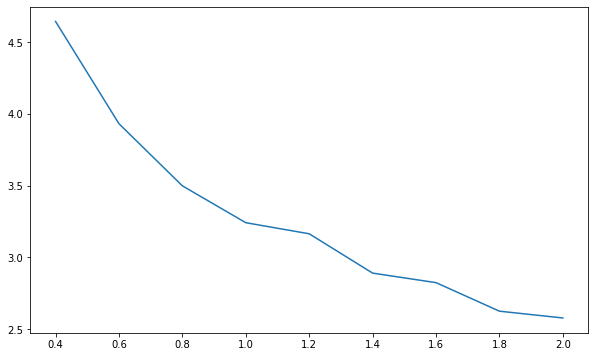

In [10]:
plt.figure(figsize=(10,6))
plt.plot(100-R["percentile"], R["ods_ratio"])

# Average precision analysis

In [11]:
def average_precision(corr_matrix, moa_matches, rank_pos=None):
    results = []
    for i in range(corr_matrix.shape[0]):
        rank = np.argsort(-corr_matrix[i,:])
        ap = metrics.average_precision(moa_matches[i, rank[1:rank_pos]])
        results.append(ap)
    return results

In [12]:
positions = [x for x in range(5,55,5)]
CRM = np.asarray(X[Y.Var1])
map_at = [np.mean( average_precision(CRM, moa_matches, pos) ) for pos in positions]

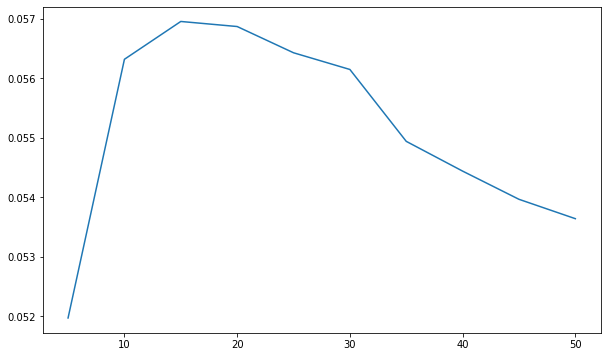

In [13]:
plt.figure(figsize=(10,6))
plt.plot(positions, map_at)

In [14]:
np.mean( average_precision(CRM, moa_matches) )

0.028057721070348228

# Recall analysis

In [15]:
def recall_at(corr_matrix, moa_matches, rank_pos=None):
    results = []
    for i in range(corr_matrix.shape[0]):
        rank = np.argsort(-corr_matrix[i,:])
        rc = np.sum(moa_matches[i, rank[1:rank_pos]]) / np.sum(moa_matches[i,:])
        results.append(rc)
    return results

In [16]:
recall = [np.mean( recall_at(CRM, moa_matches, pos) ) for pos in positions]

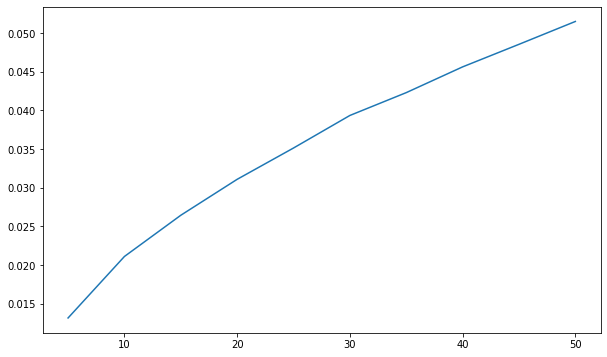

In [17]:
plt.figure(figsize=(10,6))
plt.plot(positions, recall)

In [18]:
np.mean( recall_at(CRM, moa_matches, 50) )

0.051504227933825274